In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
from tensorflow import keras
import tensorflow as tf

# gpu setting
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
    except RuntimeError as e:
        print(e)

2023-04-08 18:32:22.729600: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-04-08 18:32:23.983712: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-08 18:32:23.984648: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-04-08 18:32:24.025714: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:d8:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2023-04-08 18:32:24.025739: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-04-08 18:32:24.028712: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-04-08 18:32:24.028761: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-0

In [3]:
from model_DbyDeep_train import get_npy_DbyDeep

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [4]:
df_test = pd.read_csv('/data/2021_SJH_detectability/data_human/test.csv')
print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

Loading input peptides


# LSTM

In [5]:
print('Loading model...')
model = keras.models.load_model("log/model_DbyDeep_lstm.h5")

Loading model...


2023-04-08 18:32:49.858949: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 18:32:49.862900: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-04-08 18:32:49.864689: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:d8:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2023-04-08 18:32:49.864735: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-04-08 18:32:49.864792: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Succ

In [6]:
probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

2023-04-08 18:32:56.508099: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-04-08 18:32:56.529226: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz
2023-04-08 18:33:04.188099: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-04-08 18:33:04.854341: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2023-04-08 18:33:04.931535: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-04-08 18:33:04.932067: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


5335/5335 [==============================] - 94s 16ms/step - loss: 0.3615 - accuracy: 0.8392


Test Loss: 0.36147627234458923
Test Accuracy: 0.8391679525375366
Test AUC : 0.9189335826858336
              precision    recall  f1-score   support

       False     0.8427    0.8393    0.8410     86495
        True     0.8356    0.8391    0.8373     84211

    accuracy                         0.8392    170706
   macro avg     0.8391    0.8392    0.8391    170706
weighted avg     0.8392    0.8392    0.8392    170706



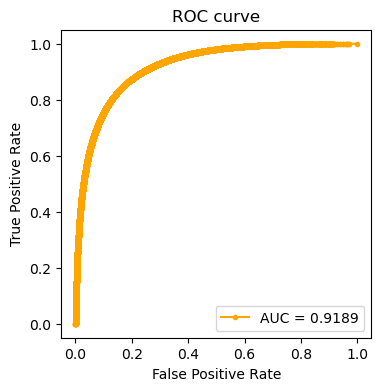

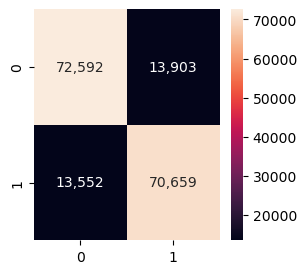

In [7]:
print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

In [8]:
np.save('log/result_LSTM_fpr.npy', fpr)
np.save('log/result_LSTM_tpr.npy', tpr)

# GRU

Loading model...
5335/5335 [==============================] - 99s 17ms/step - loss: 0.3604 - accuracy: 0.8392
Test Loss: 0.3604070544242859
Test Accuracy: 0.839226484298706
Test AUC : 0.9192842273801721
              precision    recall  f1-score   support

       False     0.8438    0.8378    0.8408     86495
        True     0.8346    0.8407    0.8376     84211

    accuracy                         0.8392    170706
   macro avg     0.8392    0.8392    0.8392    170706
weighted avg     0.8393    0.8392    0.8392    170706



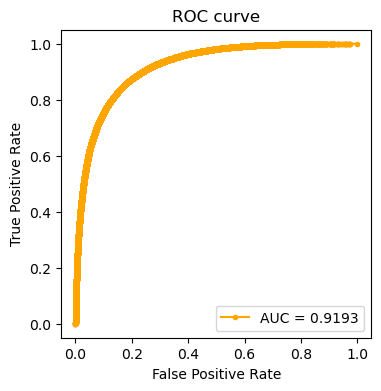

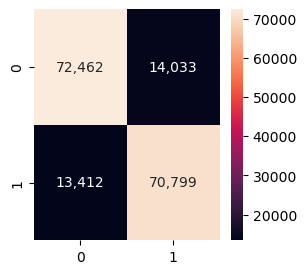

In [9]:
print('Loading model...')
model = keras.models.load_model("log/model_DbyDeep_gru.h5")

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_GRU_fpr.npy', fpr)
np.save('log/result_GRU_tpr.npy', tpr)

# Transformer

Loading model...
5335/5335 [==============================] - 20s 4ms/step - loss: 0.3652 - accuracy: 0.8380
Test Loss: 0.365175724029541
Test Accuracy: 0.837967038154602
Test AUC : 0.9174315031024861
              precision    recall  f1-score   support

       False     0.8398    0.8406    0.8402     86495
        True     0.8361    0.8353    0.8357     84211

    accuracy                         0.8380    170706
   macro avg     0.8379    0.8379    0.8379    170706
weighted avg     0.8380    0.8380    0.8380    170706



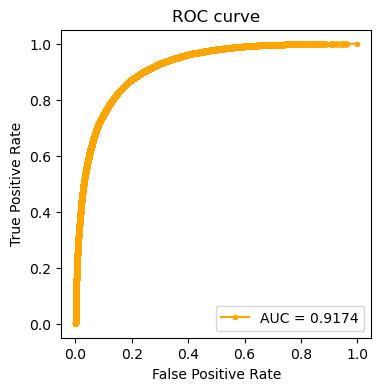

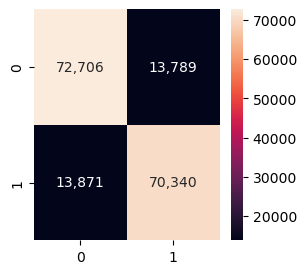

In [10]:
print('Loading model...')
model = keras.models.load_model("log/model_DbyDeep_transformer.h5")

probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

np.save('log/result_TRANSFORMER_fpr.npy', fpr)
np.save('log/result_TRANSFORMER_tpr.npy', tpr)

In [11]:
fpr=np.load('log/result_LSTM_fpr.npy')
tpr=np.load('log/result_LSTM_tpr.npy')

lt={k:-1 for k in list(map(lambda x: round(x, 3), np.linspace(0, 1, 1000)))}
for f,t in zip(fpr, tpr):
    lt[round(f, 3)] = t
    
fpr=np.load('log/result_TRANSFORMER_fpr.npy')
tpr=np.load('log/result_TRANSFORMER_tpr.npy')

tf={k:-1 for k in list(map(lambda x: round(x, 3), np.linspace(0, 1, 1000)))}
for f,t in zip(fpr, tpr):
    tf[round(f, 3)] = t

fpr=np.load('log/result_GRU_fpr.npy')
tpr=np.load('log/result_GRU_tpr.npy')

gru={k:-1 for k in list(map(lambda x: round(x, 3), np.linspace(0, 1, 1000)))}
for f,t in zip(fpr, tpr):
    gru[round(f, 3)] = t

    
lt_tpr=np.array(sorted(lt.items(), key=lambda x: x[0]))[:, 1]    
tf_tpr=np.array(sorted(tf.items(), key=lambda x: x[0]))[:, 1]
gru_tpr=np.array(sorted(gru.items(), key=lambda x: x[0]))[:, 1]

while len(lt_tpr[np.where(lt_tpr==-1)[0]-1]):
    tmp=lt_tpr[np.where(lt_tpr==-1)[0]-1]
    lt_tpr[lt_tpr==-1]=tmp

while len(tf_tpr[np.where(tf_tpr==-1)[0]-1]):
    tmp=tf_tpr[np.where(tf_tpr==-1)[0]-1]
    tf_tpr[tf_tpr==-1]=tmp

while len(gru_tpr[np.where(gru_tpr==-1)[0]-1]):
    tmp=gru_tpr[np.where(gru_tpr==-1)[0]-1]
    gru_tpr[gru_tpr==-1]=tmp

In [12]:
df=pd.DataFrame([lt_tpr, tf_tpr, gru_tpr]).T
df.columns=['LSTM', 'Transformer', 'GRU']

df.to_csv('./model_selection.csv', index=False)